---
title: "Buy vs. Rent, A Financial Modeling Workflow in Python"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2022-8-6"
description: "Using `numpy-financial` and monte-carlo simulation to evaluate investments."
draft: false
categories:  ['Python', 'Probability']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
---

In [1]:
import pandas as pd
import numpy as np
import numpy_financial as npf
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

We now simulate market returns for every month by supplying mean and standard deviation values for both home and stock market appreciation and drawing 360 samples (360 months in 30 years). For simplicity, we'll just use world-wide aggregate values from ["The Rate of Return on Everything, 1870-2015"](https://www.frbsf.org/economic-research/wp-content/uploads/sites/4/wp2017-25.pdf).


In [2]:
mu_stock = .1081
sigma_stock = .2267

mu_home = .0572
sigma_home = .1042

Given that stock and home appreciation is probably correlated, I'll have ti sample from a bivariate normal distribution using `numpy.random.Generator.multivariate_normal` - documentation [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.multivariate_normal.html), rather than the univariate distribution draw shown above. I am going to assume a correlation coefficient, $\rho_{stock,home}$ of 0.5 - a fairly clear correlation.  
In order to use that numpy function, I'll need to translate my correlation statistic into a covariance statistic, and I'll use the following formula ([source](https://en.wikipedia.org/wiki/Correlation)):  
$$ \begin{align*}
cov_{stock,home} &= \rho_{stock,home} \times \sigma_{stock} \sigma_{home} \\\
cov_{stock,home} &= 0.5 \times .2267 \times .1042 \end{align*}
$$

I calculate covariance and confirm that the covariance and correlations match up below:


In [3]:
cov = 0.5 * sigma_stock * sigma_home
print("Covariance:", cov)
print("Back to correlation:", cov / (sigma_stock * sigma_home))

Covariance: 0.01181107
Back to correlation: 0.5


Now that I have the covariance, I'll be able to sample from a bivariate normal distribution of the form shown below ([source](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case_2)).    
$$
\begin{pmatrix} Stock \\\\ Home\end{pmatrix} \sim \mathcal{N} \left[ \begin{pmatrix} \mu_{s} \\\ \mu_{h}\end{pmatrix}, \begin{pmatrix} \sigma_{s}^2 & cov_{s,h} \\\ cov_{s,h} & \sigma_{h}^2\end{pmatrix} \right]
$$  

*Note, $s$ is shorthand for stock and $h$ is shorthand for home.*  
  
Now I'll code that in Python and confirm that the means and standard deviations of our samples match what we expect:


In [4]:
def simulate_returns(mu_stock=.1081,
                     sigma_stock=.2267,
                     mu_home=.0572,
                     sigma_home=.1042,
                     condo_cost = .02,
                     years = 30,
                     seed=None):
    cov = 0.5 * sigma_stock * sigma_home
    cov_matrix = np.array([[sigma_stock**2, cov],
                [cov, sigma_home**2]])
    returns_df = pd.DataFrame(np.random
                            .default_rng(seed)
                            .multivariate_normal([mu_stock, mu_home],
                                                cov_matrix,
                                                years * 12),
                            columns=["Stock_Appreciation", "Home_Appreciation"])
    returns_df['Stock_Appreciation'] = returns_df['Stock_Appreciation'] * .6
    returns_df['Condo_Appreciation'] = returns_df['Home_Appreciation'] - condo_cost + np.random.normal(0, .005, len(returns_df))
    returns_df = (returns_df / 12)
    returns_df.index = pd.date_range(
        start=datetime.today().date(),
        periods=12*years,
        freq='MS',
        name="Date")
    return returns_df

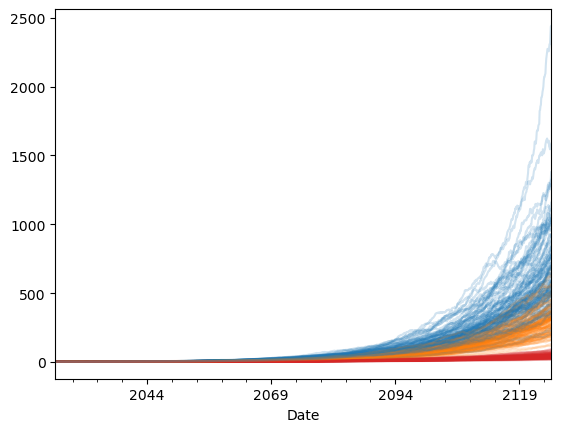

In [5]:
fig, ax = plt.subplots()
for i in range(100):
    returns_df = simulate_returns(years = 100)
    cum_returns = returns_df.add(1).cumprod()
    cum_returns['Home_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:orange")
    cum_returns['Condo_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:red")
    cum_returns['Stock_Appreciation'].plot(alpha=.2, ax=ax, legend=False, color="tab:blue")

In [6]:
returns_df

,Stock_Appreciation,Home_Appreciation,Condo_Appreciation
Date,,,
2025-07-01,0.009631,0.003545,0.002162
2025-08-01,-0.003383,-0.000335,-0.001817
2025-09-01,0.022632,0.012849,0.010832
2025-10-01,0.012088,0.013448,0.011228
2025-11-01,-0.004749,0.000117,-0.001720
...,...,...,...
2125-02-01,0.021244,0.020255,0.018959
2125-03-01,0.012719,0.013925,0.012528
2125-04-01,0.014691,-0.005659,-0.007238


In [7]:
def salt_deduction(property_tax):
    """Caps SALT deduction (property + state income tax) at $10,000"""
    return np.minimum(property_tax, 10000)

def itemized_vs_standard_deduction(itemized, standard_deduction=14600):
    """Chooses the better deduction (standard or itemized)"""
    return np.maximum(itemized, standard_deduction)

def apply_compounding(growth, start, deposits):
    growth = np.array(growth)
    deposits = np.array(deposits)
    balance = float(start)
    balances = []
    for i in range(len(growth)):
        balance = (balance + deposits[i]) * (1 + growth[i])
        balances.append(balance)
    return balances

def initiate_model(today, years = 30):
    df_own = pd.DataFrame()
    df_own["Period"] =  pd.Series(range(12*years)) + 1
    df_own["Date"] = pd.date_range(
        start=today,
        periods=12*years,
        freq='MS',
        name="Date")
    df_own = df_own.set_index('Date')
    return df_own

def mortgage_calc(df_own, interest_rate, principal):
     # Ensure "Period" column is an integer
    df_own = df_own.copy()
    df_own["Period"] = df_own["Period"].astype(int)

    # Loan term in months
    loan_term_months = 12 * 30
    
    # Compute principal and interest payments
    df_own["Principal_monthly"] = npf.ppmt(interest_rate / 12, df_own["Period"], loan_term_months, principal) * -1
    df_own["Interest_monthly"] = npf.ipmt(interest_rate / 12, df_own["Period"], loan_term_months, principal) * -1

    # Zero out values beyond the loan term
    df_own.loc[df_own["Period"] > loan_term_months, ["Principal_monthly", "Interest_monthly"]] = 0

    return df_own

today = datetime.today().date()

In [8]:
def owner_table(interest_rate=0.065,
                renovation=0,
                cost=1000000,
                hoa=0,
                returns_df=returns_df,
                mean_reno_return=.5,
                cg_tax=.15,
                closing_fees=0.035,
                selling_fees=.07,
                pct_down=.2,
                condo=False,
                start_date=None,
                years=30,
                upgrade=None,
                avg_income_growth = .02,
                upgrade_cost_today=1500000,
                max_monthly=8300,
                max_down=300000,
                pay_back_parents_years = 10,
                verbose=False):
    
    if not start_date:
        today = datetime.today().date()
    else:
        today = start_date
    df_own = initiate_model(today, years=years)
    is_year = df_own.index.month == 1
    df_own = df_own.merge(returns_df, left_index=True, right_index=True, how="left")
    
    down_payment = cost * pct_down
    principal = cost - down_payment
    buying_fees = cost*closing_fees
    reno_return = np.random.lognormal(np.log(mean_reno_return), 0.2)
    post_reno_value = (cost + renovation * reno_return)
    year = is_year.cumsum()

    df_own["Purchase_cost"] = buying_fees + down_payment + renovation
    df_own = mortgage_calc(df_own, interest_rate, principal)
    df_own['HOA_monthly'] = hoa
    df_own["PropTax_monthly"] = np.round((cost * 1.02**((year)) * 0.0144) / 12, 2)
    df_own['Max_Monthly'] = np.round((max_monthly * 1.02**((year))), 2)
    annual_proptax = df_own.resample("YE")['PropTax_monthly'].sum().rename("PropTax_annual").reindex(df_own.index, method="bfill")
    df_own = df_own.merge(
        annual_proptax, left_index=True, right_index=True, how="left"
        )
    annual_interest = df_own.resample("YE")['Interest_monthly'].sum().rename("Interest_annual").reindex(df_own.index, method="bfill")
    df_own = df_own.merge(
        annual_interest, left_index=True, right_index=True, how="left"
        )
    df_own['Total_deduction'] = itemized_vs_standard_deduction(
        df_own['Interest_annual'] + df_own["PropTax_annual"].apply(salt_deduction)
        )
    df_own['Tax_Savings_annual'] = (df_own['Total_deduction'] * 0.24 + df_own['Total_deduction'] * 0.093)
    df_own['Tax_Savings_monthly'] = df_own['Tax_Savings_annual'] / 12
    df_own['Pre_tax_monthly'] = df_own[["Principal_monthly", "Interest_monthly", "PropTax_monthly", "HOA_monthly"]].sum(axis=1)
    df_own['Post_tax_monthly'] = df_own['Pre_tax_monthly'] - df_own['Tax_Savings_monthly']
    df_own['Unproductive_cost'] = df_own['Post_tax_monthly'] - df_own["Principal_monthly"]
    df_own["Balance_Remaining"] = principal - df_own["Principal_monthly"].cumsum()
    if condo:
        df_own["Home_Value"] = apply_compounding(growth=df_own['Condo_Appreciation'],
                                            start=post_reno_value,
                                            deposits=np.zeros_like(df_own['Condo_Appreciation'])
                                            ) 
    else:
        df_own["Home_Value"] = apply_compounding(growth=df_own['Home_Appreciation'],
                                                start=post_reno_value,
                                                deposits=np.zeros_like(df_own['Home_Appreciation'])
                                                ) 
        df_own = df_own.drop(columns=['Condo_Appreciation', 'HOA_monthly'])
    
    df_own["Sale_fee"] = df_own["Home_Value"] * selling_fees
    df_own['Capital_gain'] = (df_own["Home_Value"] - cost)
    df_own["Sale_tax"]  = np.maximum(0, (df_own['Capital_gain'] - 500000)) * cg_tax
    df_own['Profit'] = df_own['Capital_gain'] - df_own["Sale_tax"] - df_own["Sale_fee"] - buying_fees + down_payment + df_own["Principal_monthly"].cumsum()
    # Opp Costs
    added_costs = np.zeros_like(df_own['Post_tax_monthly'].values)
    if df_own["Purchase_cost"].iloc[0] <= max_down:
        savings_1 = (max_down - df_own["Purchase_cost"].iloc[0])
    else:
        savings_1 = 0
        additional_monthly = (df_own["Purchase_cost"].iloc[0] - max_down) / pay_back_parents_years / 12
        added_costs[:pay_back_parents_years*12] = additional_monthly
        if verbose:
            print("\tTotal Reno:", renovation)
            print("\tReno excess monthly:", additional_monthly)
        df_own['Pre_tax_monthly'] = df_own['Pre_tax_monthly'] + added_costs
        df_own['Post_tax_monthly'] = df_own['Post_tax_monthly'] + added_costs

    diff_0 = df_own['Max_Monthly'] - df_own['Post_tax_monthly'] - added_costs
    diff_0[diff_0 < 0] = 0
    df_own['Stock_savings'] = (
        pd.Series(apply_compounding(df_own['Stock_Appreciation'],
                                    0,
                                    diff_0)).multiply(.85).values +
                                    pd.Series(apply_compounding(
                                        df_own['Stock_Appreciation'],
                                        savings_1,
                                        np.zeros_like(df_own['Stock_Appreciation']))).multiply(.85).values
    )
    df_own['Full_profit'] = df_own['Stock_savings'] + df_own['Profit']
    if upgrade is not None:
        house_2_max_dp = df_own['Full_profit'][upgrade]
        years_elapsed = pd.to_datetime(upgrade).year - today.year - 1
        house_2_max_monthly = max_monthly * (1 + avg_income_growth)**int(years_elapsed)
        df_own['_upgrade'] = apply_compounding(growth=df_own['Home_Appreciation'],
                                         start=upgrade_cost_today,
                                         deposits=np.zeros_like(
                                             df_own['Home_Appreciation'])
                                         )
        house_2_cost = df_own.loc[upgrade, '_upgrade']
        new_house = pd.concat([
            df_own[:upgrade].iloc[:-1],
            owner_table(start_date=upgrade,
                        cost=house_2_cost,
                        years=years,
                        max_down=house_2_max_dp,
                        max_monthly=house_2_max_monthly)
            ]).iloc[:years*12]
        if verbose:
            print("Upgrade house price:", house_2_cost)
            print("\tmonthly postax Year 1:", new_house.loc[upgrade, 'Post_tax_monthly'])
            print("\tmonthly interest+tax Year 1:", new_house.loc[upgrade, 'Unproductive_cost'])
            print("\tmonthly pretax", new_house.loc[upgrade, 'Pre_tax_monthly'])
        return new_house
    else:
        return df_own

In [9]:
owner_table(years=30, upgrade='2027-01-01')[['Stock_savings',
                                             'Capital_gain',
                                             'Sale_fee',
                                             'Full_profit',
                                             'Home_Value',
                                             'Max_Monthly']].loc["2026-01-01":].head(20)

,Stock_savings,Capital_gain,Sale_fee,Full_profit,Home_Value,Max_Monthly
Date,,,,,,
2026-01-01,78645.525668,70242.971701,74917.008019,244116.977276,1.070243e+06,8466.00
2026-02-01,81982.057233,78306.731177,75481.471182,255703.887400,1.078307e+06,8466.00
2026-03-01,86322.930401,89875.892166,76291.312452,271559.230898,1.089876e+06,8466.00
2026-04-01,89132.066597,108817.581592,77617.230711,292743.379268,1.108818e+06,8466.00
2026-05-01,92979.783653,105982.814046,77418.796983,294718.116072,1.105983e+06,8466.00
2026-06-01,97177.356856,110544.112620,77738.087883,303925.185344,1.110544e+06,8466.00
2026-07-01,100736.974267,97938.652846,76855.705699,296533.370790,1.097939e+06,8466.00
2026-08-01,103722.494719,94693.326996,76628.532890,297276.563574,1.094693e+06,8466.00
2026-09-01,107184.086575,104011.212838,77280.784899,310183.817022,1.104011e+06,8466.00


<AxesSubplot: xlabel='Date'>

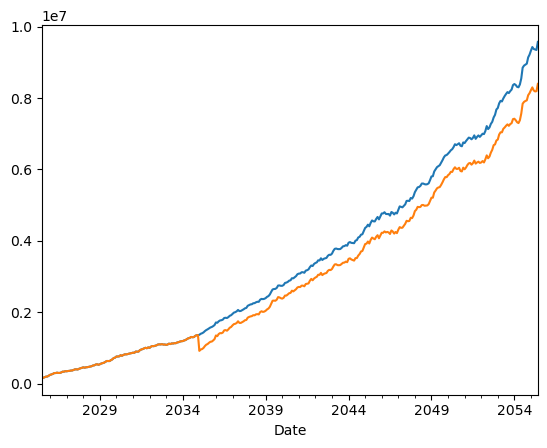

In [10]:
owner_table(years=30)['Full_profit'].plot(label='')
owner_table(years=30, upgrade='2035-01-01')['Full_profit'].plot()

<AxesSubplot: xlabel='Date'>

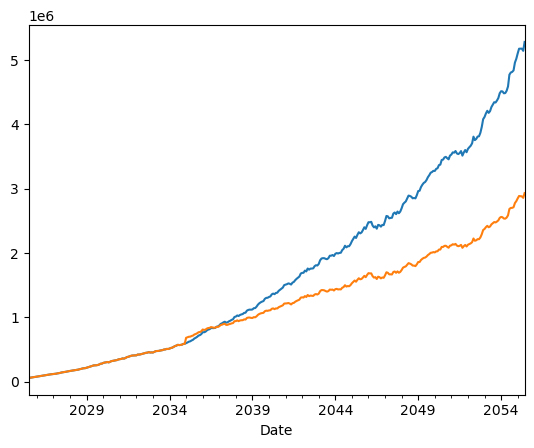

In [11]:
owner_table(years=30)['Stock_savings'].plot(label='')
owner_table(years=30, upgrade='2035-01-01')['Stock_savings'].plot()

<AxesSubplot: xlabel='Date'>

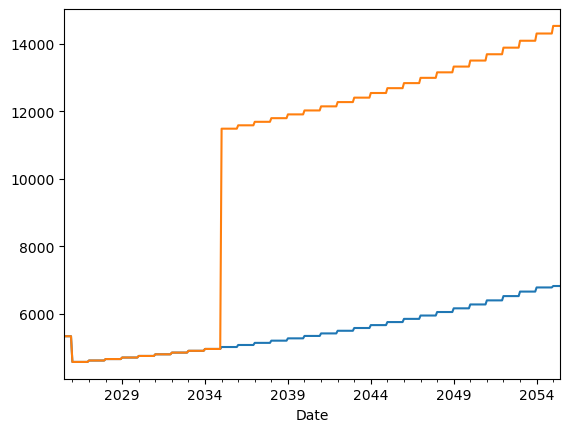

In [12]:
owner_table(years=30)['Post_tax_monthly'].plot(label='')
owner_table(years=30, upgrade='2035-01-01')['Post_tax_monthly'].plot()

In [13]:
def compare(scenario_1, scenario_2, returns_df, verbose=False, max_monthly=8000, max_down=300000):
    series_1 = owner_table(**scenario_1)
    series_2 = owner_table(**scenario_2)
    both = [series_1, series_2]
    if verbose:
        print(scenario_1['cost'])
        print("\tmonthly postax Year 1:", series_1['Post_tax_monthly'].iloc[0])
        print("\tmonthly interest+tax Year 1:", series_1['Unproductive_cost'].iloc[0])
        print("\tmonthly postax Year 2:", series_1['Post_tax_monthly'].loc['2026-01-01'])
        print("\tmonthly interest+tax Year 2:", series_1['Unproductive_cost'].loc['2026-01-01'])
        print("\tmonthly pretax", series_1['Pre_tax_monthly'].iloc[0])
        print(scenario_2['cost'])
        print("\tmonthly postax Year 1:", series_2['Post_tax_monthly'].iloc[0])
        print("\tmonthly interest+tax Year 1:", series_2['Unproductive_cost'].iloc[0])
        print("\tmonthly postax Year 2:", series_2['Post_tax_monthly'].loc['2026-01-01'])
        print("\tmonthly interest+tax Year 2:", series_2['Unproductive_cost'].loc['2026-01-01'])
        print("\tmonthly pretax", series_2['Pre_tax_monthly'].iloc[0])
    total_cost_1 = series_1['Purchase_cost'].iloc[0]
    total_cost_2 = series_2['Purchase_cost'].iloc[0]
    if verbose:
        print(scenario_1['cost'])
        print("\tupfront cost", total_cost_1)
        print(scenario_2['cost'])
        print("\tupfront cost", total_cost_2)
        print("\tDifference", (max(total_cost_1, total_cost_2) - min(total_cost_1, total_cost_2)))
    savings_1 = (max_down - total_cost_1) if (max_down - total_cost_1) > 0 else 0
    both[0]['Profit'] = both[0]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                savings_1,
                                                                np.zeros_like(returns_df['Stock_Appreciation']))
                                                                ).multiply(.85)
    savings_2 = (max_down - total_cost_2) if (max_down - total_cost_2) > 0 else 0
    both[1]['Profit'] = both[1]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                savings_2,
                                                                np.zeros_like(returns_df['Stock_Appreciation']))
                                                                ).multiply(.85)
    ##
    ##
    diff_0 = max_monthly - both[0]['Post_tax_monthly']
    diff_0[diff_0 < 0] = 0
    both[0]['Profit'] = both[0]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                0,
                                                                diff_0)
                                                                ).multiply(.85)
    diff_1 = max_monthly - both[1]['Post_tax_monthly']
    diff_1[diff_1 < 0] = 0
    both[1]['Profit'] = both[1]['Profit'].add(apply_compounding(returns_df['Stock_Appreciation'],
                                                                0,
                                                                diff_1)
                                                                ).multiply(.85)
    ##
    final_profit_1 = both[0]['Profit'].iloc[-1]
    final_profit_2 = both[1]['Profit'].iloc[-1]
    if verbose:
        print(scenario_1['cost'])
        print("\tFinal", final_profit_1)
        print(scenario_2['cost'])
        print("\tFinal", final_profit_2) 
    return both 

1350000
	monthly postax Year 1: 6953.803179428955
	monthly interest+tax Year 1: 5572.130681509953
	monthly postax Year 2: 6154.556342228932
	monthly interest+tax Year 2: 4740.0280964360345
	monthly pretax 8064.172497919002
980000
	monthly postax Year 1: 5968.9336660546
	monthly interest+tax Year 1: 4044.954124355373
	monthly postax Year 2: 5312.68411016125
	monthly interest+tax Year 2: 3364.853729264676
	monthly pretax 6774.9795416992265
1350000
	upfront cost 327250.0
980000
	upfront cost 430300.0
	Difference 103050.0
1350000
	Final 5814185.898288703
980000
	Final 6257171.796256697
	Total Reno: 10000
	Reno excess monthly: 227.08333333333334
	Total Reno: 200000
	Reno excess monthly: 1085.8333333333333


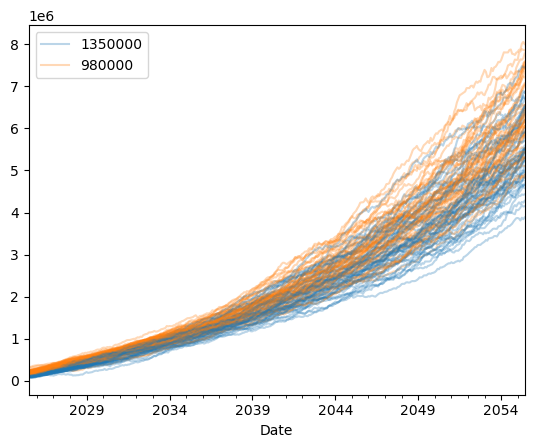

In [25]:
fig, ax = plt.subplots()
profits = {}
yr_10 = {}
yr_20 = {}
yr = {}
ir = 0.05625
for i in range(50):
    returns_df = simulate_returns()
    # No Reno
    scenario_1 = {'cost': 1_350_000, 'renovation': 10_000,
                  'mean_reno_return': .1,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir,
                #   'upgrade_cost_today':1500000,
                #   'upgrade': '2033-01-01'
                  }
    scenario_2 = {'cost': 980000, 'renovation': 200000,
                  'mean_reno_return': 1,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir,
                #   'upgrade_cost_today':1500000,
                #   'upgrade': '2033-01-01'
                  }
    cornell = {'cost': 1_075_000, 'renovation': 15_000,
                  'mean_reno_return': 1,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir,
                  'upgrade_cost_today':1500000,
                  'upgrade': '2033-01-01'
                  }
    fha = {'cost': 1_200_001, 'renovation': 70000,
                  'mean_reno_return': 1,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .035, 'interest_rate':.07,
                #   'upgrade_cost_today':1500000,
                #   'upgrade': '2033-01-01'
                  }
    duplex = {'cost': 1_150_000, 'renovation': 80_000,
                  'hoa':-1241, 'condo': True,
                  'mean_reno_return': 1,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir,
                #   'upgrade_cost_today':1500000,
                #   'upgrade': '2033-01-01'
                  }
    # Reno
    berkeley_way = {'cost': 1_050_000, 'renovation': 100_000,
                  'mean_reno_return': 2,
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}
    acroft = {'cost': 1_200_001, 'renovation': 120_000,
                  'mean_reno_return': 2,
                  # 'upgrade': '2033-01-01',
                  'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}
    mcgee = {'cost': 1_250_001, 'renovation': 10_000,
              'mean_reno_return': 1,
              'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}
    upgrader = {'cost': 1_100_000, 'renovation': 10_000,
              'mean_reno_return': .1,
              'upgrade': '2033-01-01',
              'returns_df': returns_df, 'pct_down': .2, 'interest_rate':ir}

    
    if i == 0:
        both = compare(scenario_1, scenario_2, returns_df, verbose=True)
        series_1 = owner_table(verbose=True, **scenario_1)
        series_2 = owner_table(verbose=True, **scenario_2)
        profits[str(scenario_1['cost'])] = []
        profits[str(scenario_2['cost'])] = []
        profits[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[-1])
        profits[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[-1])
        yr[str(scenario_1['cost'])] = []
        yr[str(scenario_2['cost'])] = []
        yr[str(scenario_1['cost'])].append(both[0]['Profit'])
        yr[str(scenario_2['cost'])].append(both[1]['Profit'])
        yr_10[str(scenario_1['cost'])] = []
        yr_10[str(scenario_2['cost'])] = []
        yr_10[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[10*12])
        yr_10[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[10*12])
        yr_20[str(scenario_1['cost'])] = []
        yr_20[str(scenario_2['cost'])] = []
        yr_20[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[20*12])
        yr_20[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[20*12])
        both[0]['Profit'].plot(ax=ax, label=str(scenario_1['cost']), color="tab:blue", alpha=.3)
        both[1]['Profit'].plot(ax=ax, label=str(scenario_2['cost']), color="tab:orange", alpha=.3)
    else:
       both = compare(scenario_1, scenario_2, returns_df)
       profits[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[-1])
       profits[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[-1])
       yr[str(scenario_1['cost'])].append(both[0]['Profit'])
       yr[str(scenario_2['cost'])].append(both[1]['Profit'])
       yr_10[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[10*12])
       yr_10[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[10*12])
       yr_20[str(scenario_1['cost'])].append(both[0]['Profit'].iloc[20*12])
       yr_20[str(scenario_2['cost'])].append(both[1]['Profit'].iloc[20*12])
       both[0]['Profit'].plot(ax=ax, label="_k", color="tab:blue", legend=False, alpha=.3)
       both[1]['Profit'].plot(ax=ax, label="_l", color="tab:orange", legend=False, alpha=.3) 
outcomes_df = pd.concat([
    pd.concat(yr[str(scenario_1['cost'])], axis=1).T.assign(variable=str(scenario_1['cost'])),
    pd.concat(yr[str(scenario_2['cost'])], axis=1).T.assign(variable=str(scenario_2['cost']))
])
outcomes_df.columns = both[0].index.astype(str).tolist() + outcomes_df.columns[len(both[0]):].tolist()
ax.legend();

In [35]:
pd.set_option('display.max_columns', None)


In [37]:
series_1.head(30)

,Period,Stock_Appreciation,Home_Appreciation,Purchase_cost,Principal_monthly,Interest_monthly,PropTax_monthly,Max_Monthly,PropTax_annual,Interest_annual,Total_deduction,Tax_Savings_annual,Tax_Savings_monthly,Pre_tax_monthly,Post_tax_monthly,Unproductive_cost,Balance_Remaining,Home_Value,Sale_fee,Capital_gain,Sale_tax,Profit,Stock_savings,Full_profit
Date,,,,,,,,,,,,,,,,,,,,,,,,
2025-07-01,1,-0.004282,0.001479,327250.0,1154.589165,5062.500000,1620.00,8300.00,9720.0,30293.308774,40013.308774,13324.431822,1110.369318,8064.172498,6953.803179,5572.130682,1.078845e+06,1.352969e+06,94707.860268,2969.432396,0.0,132166.161293,947.172910,133113.334203
2025-08-01,2,0.009765,0.008796,327250.0,1160.001301,5057.087863,1620.00,8300.00,9720.0,30293.308774,40013.308774,13324.431822,1110.369318,8064.172498,6953.803179,5566.718545,1.077685e+06,1.364870e+06,95540.903405,14870.048649,0.0,144393.735709,1916.957522,146310.693231
2025-09-01,3,0.003415,0.016276,327250.0,1165.438807,5051.650357,1620.00,8300.00,9720.0,30293.308774,40013.308774,13324.431822,1110.369318,8064.172498,6953.803179,5561.281039,1.076520e+06,1.387084e+06,97095.898651,37084.266438,0.0,166218.397060,2877.997989,169096.395049
2025-10-01,4,0.000918,0.010227,327250.0,1170.901802,5046.187363,1620.00,8300.00,9720.0,30293.308774,40013.308774,13324.431822,1110.369318,8064.172498,6953.803179,5555.818044,1.075349e+06,1.401271e+06,98088.946093,51270.658474,0.0,180582.643456,3832.760092,184415.403548
2025-11-01,5,-0.010614,-0.003810,327250.0,1176.390404,5040.698761,1620.00,8300.00,9720.0,30293.308774,40013.308774,13324.431822,1110.369318,8064.172498,6953.803179,5550.329442,1.074173e+06,1.395932e+06,97715.212239,45931.603413,0.0,176793.712654,4733.227951,181526.940604
2025-12-01,6,0.016721,0.012764,327250.0,1181.904734,5035.184431,1620.00,8300.00,9720.0,30293.308774,40013.308774,13324.431822,1110.369318,8064.172498,6953.803179,5544.815112,1.072991e+06,1.413749e+06,98962.461418,63749.448828,0.0,194546.213623,5779.526137,200325.739760
2026-01-01,7,0.013598,0.011274,327250.0,1187.444912,5029.644252,1652.40,8466.00,19828.8,59982.564169,69982.564169,23304.193868,1942.016156,8096.572498,6154.556342,4740.028096,1.071803e+06,1.429688e+06,100078.160970,79688.013864,0.0,210556.524019,7653.915032,218210.439050
2026-02-01,8,0.002356,-0.000355,327250.0,1193.011060,5024.078104,1652.40,8466.00,19828.8,59982.564169,69982.564169,23304.193868,1942.016156,8096.572498,6154.556342,4734.461948,1.070610e+06,1.429181e+06,100042.675963,79181.085190,0.0,211278.091413,9447.829203,220725.920616
2026-03-01,9,0.013742,0.015550,327250.0,1198.603300,5018.485865,1652.40,8466.00,19828.8,59982.564169,69982.564169,23304.193868,1942.016156,8096.572498,6154.556342,4728.869709,1.069412e+06,1.451406e+06,101598.387805,101405.540065,0.0,233145.437746,11373.710915,244519.148661


In [26]:
selection = '2032-01-01'
df_select = outcomes_df[[selection, 'variable']]
df_select = df_select.rename(columns={selection: 'value'})
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data=df_select).fit(q=0.5)
print("Q-Reg:")
print(mod.summary().tables[-1])
mod = sm.OLS.from_formula("value ~ I(variable)", data=df_select).fit()
print("Linear-Reg:")
print(mod.summary().tables[1])

Q-Reg:
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              7.169e+05   2.02e+04     35.465      0.000    6.77e+05    7.57e+05
I(variable)[T.980000]  1.043e+05   2.86e+04      3.648      0.000    4.75e+04    1.61e+05
Linear-Reg:
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              7.094e+05   1.37e+04     51.601      0.000    6.82e+05    7.37e+05
I(variable)[T.980000]  9.913e+04   1.94e+04      5.099      0.000    6.05e+04    1.38e+05


In [27]:
df_select.groupby('variable')['value'].agg(['mean', 'median'])

,mean,median
variable,,
1350000,709416.216492,718424.432110
980000,808549.361035,823682.296301


#### 10yr

In [28]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(yr_10).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.101e+06,2.7e+04,40.730,0.000,1.05e+06,1.15e+06
I(variable)[T.980000],9.794e+04,3.82e+04,2.562,0.012,2.21e+04,1.74e+05


In [29]:
mod.params.iloc[-1]/10/12

816.1505696045351

#### 20 yr

In [30]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(yr_20).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.722e+06,8.15e+04,33.423,0.000,2.56e+06,2.88e+06
I(variable)[T.980000],3.482e+05,1.15e+05,3.023,0.003,1.2e+05,5.77e+05


In [31]:
mod.params.iloc[-1]/20/12

1450.7390924500303

#### 30 yr

In [32]:
mod = sm.regression.quantile_regression.QuantReg.from_formula("value ~ I(variable)", data =pd.DataFrame(profits).melt()).fit(q=0.5)
mod.summary().tables[-1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.498e+06,1.79e+05,30.768,0.000,5.14e+06,5.85e+06
I(variable)[T.980000],7.099e+05,2.53e+05,2.809,0.006,2.08e+05,1.21e+06
